In [1]:
#%% solve the Helmoltz equation with Hard-constrain DNN
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv
import pandas as pd

## Environment preparing
device = torch.device('cpu')
if torch.cuda.is_available():
  # Cuda
  device = torch.device('cuda')
# if torch.has_mps:
#   # Mac.
#   device = torch.device('mps:0')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
#%% PINN network
class ResBlock(nn.Module):
  def __init__(self, in_dim) -> None:
    super().__init__()
    self.b = nn.Sequential(nn.Linear(in_dim, in_dim), nn.Tanh())
  def forward(self, X):
    return self.b(X) + X
    
class PINN(nn.Module):
  def __init__(self,in_dim, h_dim, out_dim, H, R):
    super(PINN, self).__init__()
    self.H = H
    self.R = R
    self.model = nn.Sequential(
        nn.Linear(in_dim,h_dim),
        nn.Tanh(),
        ResBlock(h_dim),
        # nn.LeakyReLU(),
        # ResBlock(h_dim),
        nn.Dropout(),
        # ResBlock(h_dim),
        # ResBlock(h_dim),
        ResBlock(h_dim),
        nn.Linear(h_dim, out_dim),
    )
    self.transform = torch.tensor([1/self.R, 1/self.H], requires_grad=False).to(device)

  def alpha(self, X):
    return torch.sin(.5 * torch.pi * X[:, 1:2] / self.H) * torch.square(X[:, 1:2] / self.H - 1)
  def forward(self, x):
    out = self.model((x * self.transform) - 0.5)
    return self.alpha(x) * out

In [3]:
def loss_boundary_condition(model, Xb, normal, g):
  y = model(Xb)
  (dydx, ) = torch.autograd.grad(
    y, Xb, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True
  )
  dydr = dydx[:, 0:1]
  dydz = dydx[:, 1:2]
  nr = normal[:, 0:1]
  nz = normal[:, 1:2]
  dir_diff = dydr * nr + dydz * nz
  loss = torch.square(dir_diff - g).sum()
  return loss

In [4]:
# loss for data_res constraint
def loss_res_p(model_pr,X_ij,pd_ij):
  # t_p_ij means the true value of p
  p = model_pr(X_ij)
  loss_res = torch.nn.functional.l1_loss(p, pd_ij)
  return loss_res

In [5]:
def loss_eq(model, X, k):
  p = model(X)
  def _dif(f, x):
    return torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), retain_graph=True, create_graph=True)
  (dpdX, ) = _dif(p, X)
  dpdr = dpdX[:, 0:1]
  dpdz = dpdX[:, 1:2]
  d2pdr2 = _dif(dpdr, X)[0][:, 0:1]
  d2pdz2 = _dif(dpdz, X)[0][:, 1:2]
  lhs = d2pdr2 + dpdr / (X[:, 0:1] + 0.01)  + d2pdz2 + k**2 * p
  rhs = 0
  return torch.square(lhs).sum()

In [6]:
def loss_total(model, 
                X_ij, # Data Points
                P_ij, # Data Point value
                X_rand,     # Random Sampled Points
                X_bc,       # Neumann BC Points
                g_bc,       # Neumann BC Values
                N_bc,  # Neumann BC Normal vectors.
                k):
  l_eq = loss_eq(model, X_rand, k)
  l_eq_data = loss_eq(model, X_ij, k)
  l_bc = loss_boundary_condition(model, X_bc, N_bc, g_bc)
  l_data = loss_res_p(model,X_ij, P_ij)
  return l_eq+l_bc+l_eq_data+100*(l_data), l_data, l_eq, l_bc

In [7]:
# X_d stand for the data value of X
r_d = pd.read_csv('data/K_300_r.csv')['r']
r_d = torch.tensor(r_d).reshape(-1,1)
z_d = pd.read_csv('data/K_300_z.csv')['z']
z_d = torch.tensor(z_d).reshape(-1,1)
l = list(np.linspace(0, 1, 200))
p_d_i = pd.read_csv('data/K_300_pi.csv',names=l)[l].values
p_d_r = pd.read_csv('data/K_300_pr.csv',names=l)[l].values
p_d_r = p_d_r.astype(np.float32)
p_d_i = p_d_i.astype(np.float32)
r,z = np.meshgrid(r_d[0:200], z_d[0:100])
r = r.reshape(100*200,1)
z = z.reshape(100*200,1)
X_ij = np.hstack([r, z]) # [[r[0:199],0],[r[0:199],1],...,]
X_ij = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
pd_r_ij = p_d_r[0:100,0:200]
pd_i_ij = p_d_i[0:100,0:200]
pd_r_ij = pd_r_ij.reshape(100*200,1)
pd_i_ij = pd_i_ij.reshape(100*200,1)
pd_r_ij = torch.from_numpy(pd_r_ij).double().to(device)
pd_i_ij = torch.from_numpy(pd_i_ij).double().to(device)
pd_ij = torch.complex(pd_r_ij,pd_i_ij).to(device)

# Question：这样做完之后 X_ij 和 pd_ij 是否对应

In [8]:
## define g,h,alpha(al),beta(be),q and its grad
p0 = 0.5   # reference pressure
H = 100     # heigh of sea
zs = 20
c = 1500
f = 300
k = f*2*np.pi/c

model = PINN(2, 16, 1, H, 200)
model = model.to(device)
print(model)
for n, p in model.named_parameters():
  torch.nn.init.uniform_(p, a = 0, b = 0.3)

# Get boundary data
N_bound = 100
random_r_bo = random.sample(range(0,199), N_bound)
random_z_bo = 100*np.ones(N_bound)
r_bound = r_d[random_r_bo,0:1].numpy()
z_bound = z_d[random_z_bo,0:1].numpy()
X_bound = np.hstack([r_bound,z_bound])
X_bound = torch.from_numpy(X_bound).requires_grad_(True).double().to(device)


def Normal_vec(r,z,k):
    # for flat bottom
    # Normal_vec_ij = torch.empty(list(r.size())[0],2)
    # Normal_vec_ij[:,0] = 0.0*r
    # Normal_vec_ij[:,1] = 1.0*r
    N_r = 0.0 * r
    N_z = 1.0 * np.ones_like(r)
    # for clien bottom (0,H) (R,B)
    # R = 1000
    # B = 10
    # Normal_vec_ij[:,0] = -B/R*r
    # Normal_vec_ij[:,1] = 1.0*r
    return np.hstack([N_r,N_z])

norm_vec_bound = torch.from_numpy(Normal_vec(r_bound,z_bound, k)).to(device)
g_bound = torch.from_numpy(0.0 * r_bound).to(device)
q_ij = 0.0 * r
g_ij = 0.0 * r
# q_ij[z==zs & r == 0] = 1

PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): ResBlock(
      (b): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
    )
    (3): Dropout(p=0.5, inplace=False)
    (4): ResBlock(
      (b): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
    )
    (5): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [9]:
loss_boundary_condition(model, X_bound, norm_vec_bound, g_bound)

tensor(0., grad_fn=<SumBackward0>)

In [10]:
loss_res_p(model, X_ij, pd_r_ij).item()

0.3592654391654933

In [11]:
loss_eq(model, X_ij, k)

tensor(9394.9370, grad_fn=<SumBackward0>)

In [12]:
loss_total(model, X_ij, pd_r_ij, X_ij, X_bound, g_bound, norm_vec_bound, k)

(tensor(18765.5431, grad_fn=<AddBackward0>),
 tensor(9335.7986, grad_fn=<AddBackward0>),
 tensor(9394.1834, grad_fn=<SumBackward0>),
 tensor(0., grad_fn=<SumBackward0>))

In [13]:
optm = torch.optim.Adam(model.parameters())

In [14]:
model.train()

loss_hist_r = []
pbar = trange(1000)
pbar.display()
for step in pbar:
  # lr_adjust(step, optimizer_r)
  optm.zero_grad()
  X_rand = (torch.rand((128, 2), requires_grad=True) * torch.tensor([200, 100])).to(device)
  l, ld, leq, lbc = loss_total(model, X_ij, pd_r_ij, X_rand, X_bound, g_bound, norm_vec_bound, k)
  l.backward()
  optm.step()
  if step % 3 == 0:
      real = model(X_ij)
      err = torch.square(pd_r_ij - real).mean().detach().cpu().numpy()
      pbar.set_postfix({
            'loss': '{0:.3e}'.format(l.item()),
            'eq': '{0:.3e}'.format(leq.item()),
            'bc': '{0:.3e}'.format(lbc.item()),
            'da': '{0:.3e}'.format(ld.item()),
            'l2': "{0: .3e}".format(np.sqrt(err))
      })
  loss_hist_r.append(l.item())

100%|██████████| 1000/1000 [01:19<00:00, 12.53it/s, loss=2.809e+00, eq=8.084e-03, bc=0.000e+00, da=1.302e+00, l2=3.031e-02]


In [15]:
real = model(X_ij)
err = torch.square(pd_r_ij - real).mean().detach().cpu().numpy()
print(f"mse = {err}")
print(f'dataloss = {loss_res_p(model, X_ij, pd_r_ij).item()}')

mse = 0.0009187870698703604
dataloss = 0.015097336916819495


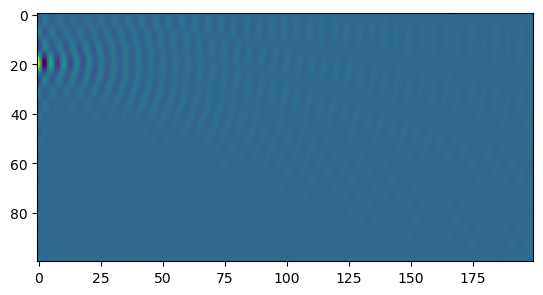

In [16]:
plt.imshow(pd_r_ij.cpu().numpy().reshape(100, 200))

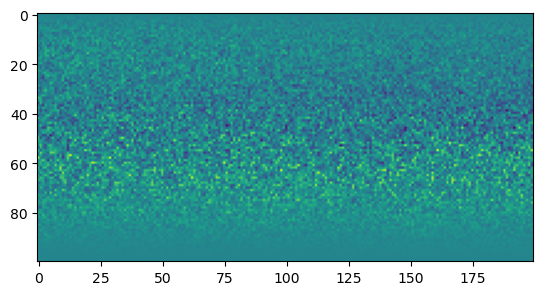

In [17]:
s = (real.detach().cpu().numpy().reshape(100, 200))
plt.imshow(s)

In [18]:
s.max()

0.025516160176164086

In [19]:
pd_r_ij.max()

tensor(1.)

In [20]:
p_d_r.shape

(101, 200)

In [21]:
pd.read_csv('data/K_300_r.csv')['r'].shape

(200,)

In [22]:
X_ij

tensor([[  0.0000,   0.0000],
        [  1.0050,   0.0000],
        [  2.0101,   0.0000],
        ...,
        [197.9899,  99.0000],
        [198.9950,  99.0000],
        [200.0000,  99.0000]], requires_grad=True)

In [23]:
X_ij.shape

torch.Size([20000, 2])

In [24]:
p_d_r.shape

(101, 200)

In [25]:
p_d_r

array([[ 1.6700000e-14,  7.0500001e-15, -5.5100001e-15, ...,
        -3.2300001e-15, -3.3299999e-15,  4.0000000e-15],
       [-7.9628706e-02, -3.5687242e-02,  3.3661310e-02, ...,
        -1.1431300e-03, -1.1467210e-03,  6.4760097e-04],
       [-1.3044952e-01, -5.8747739e-02,  5.4796342e-02, ...,
        -2.8125141e-03, -2.5382671e-03,  1.5696960e-03],
       ...,
       [ 8.7225670e-03,  4.1419012e-03, -3.3657481e-03, ...,
        -2.1896752e-02, -4.8550870e-03,  1.8260198e-02],
       [ 2.4283919e-02,  1.1458291e-02, -9.4666947e-03, ...,
        -2.6805490e-02, -4.7217552e-03,  2.3267288e-02],
       [ 2.9805962e-02,  1.4043363e-02, -1.1646398e-02, ...,
        -2.4923904e-02, -3.8846489e-03,  2.2022292e-02]], dtype=float32)

In [26]:
pd_r_ij

tensor([[ 1.6700e-14],
        [ 7.0500e-15],
        [-5.5100e-15],
        ...,
        [-2.6805e-02],
        [-4.7218e-03],
        [ 2.3267e-02]])

In [27]:
r

array([[  0.        ],
       [  1.00502515],
       [  2.0100503 ],
       ...,
       [197.9899445 ],
       [198.9949799 ],
       [200.        ]])